In [0]:
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# Read in patents filtered based on codes
df_content = spark.read.parquet("/Volumes/workspace/default/kaggle_filtered_1/patents.parquet/")

# Create content column
df_content = df_content.withColumn("content", 
                       F.concat_ws("\n\n", 
                                   F.concat(F.lit("Title: "), df_content["title"]), 
                                   F.concat(F.lit("Abstract: "), df_content["abstract"]), 
                                   F.concat(F.lit("Claims: "), df_content["claims"])))

df_content = df_content.select("publication_number", "content")

In [0]:
# Function for comparing two models
def compare_models(df, prompt, large_model, small_model):
    df_results = (df
                  .withColumn("prompt", F.concat_ws('\n', F.lit(prompt), F.lit("**Patent Data**"), "content"))
                  .withColumn("large_model_results", F.expr(f"""ai_query('{large_model}', prompt)"""))
                  .withColumn("small_model_results", F.expr(f"""ai_query('{small_model}', prompt)"""))
                  .withColumn("large_model_results_str", F.from_json("large_model_results", "classification string, confidence string"))
                  .withColumn("small_model_results_str", F.from_json("small_model_results", "classification string, confidence string"))
                  .select("publication_number",
                          F.col("large_model_results_str.classification").alias("large_classification"),
                          F.col("large_model_results_str.confidence").alias("large_confidence"),
                          F.col("small_model_results_str.classification").alias("small_classification"),
                          F.col("small_model_results_str.confidence").alias("small_confidence")))
    return df_results

# Function for classifying patents from chosen model
def classify_patents(df, prompt, model):
    df_results = (df
                  .withColumn("prompt", F.concat_ws('\n', F.lit(prompt), F.lit("**Patent Data**"), "content"))
                  .withColumn("small_model_results", F.expr(f"""ai_query('{model}', prompt)"""))
                  .withColumn("small_model_results_str", F.from_json("small_model_results", "classification string, confidence string"))
                  .select("publication_number",
                          F.col("small_model_results_str.classification").alias("small_classification"),
                          F.col("small_model_results_str.confidence").alias("small_confidence")))
    return df_results

In [0]:
patent_classification_prompt = """
BATTERY PATENT CLASSIFICATION

Analyze the patent text to determine if it pertains to solid-state batteries, traditional lithium-ion batteries, or if it's an unrelated patent. Look out for the following key indicators in the patent text.

**Key Indicators:**

**Solid-State Batteries:**
- Clear mention of solid electrolytes (ceramic or polymer)
- No separate separator present
- Specific architectures like thin films or bulk solid-state designs- Mention of materials such as LLZO, LAGP, or solid polymer electrolytes

**Traditional Li-ion Batteries:**
- Clear presence of liquid or gel electrolytes
- Mention of separators or membranes
- Reference to anodes, cathodes, or current collectors
- Focus on liquid solvents or polyethylene/polypropylene separators 

**Important Notes:**
- Look for explicit and unambiguous mentions of battery type.
- Some patents may discuss hybrid systems; classify as 'unclear' if it's not definitively one type.
- If the patent does not relate to batteries or their components, please classify as 'unrelated'.
- Use all of your evidence at hand to provide a confidence rating of high, medium or low.

**Output JSON Format:**
{
  "classification": "solid-state battery" | "traditional lithium-ion battery" | "unclear" | "unrelated",
  "confidence": "high" | "medium" | "low"
}

Please strictly adhere to this JSON format and do not provide any additional information.
"""

In [0]:
large_model = "databricks-meta-llama-3-1-405b-instruct"
small_model = "databricks-mixtral-8x7b-instruct"

In [0]:
df_content_sample = df_content.orderBy(F.rand(seed=1)).limit(300)

df_results = compare_models(df_content_sample, patent_classification_prompt, large_model, small_model)

df_results.display()

In [0]:
# Save and upload results
df_results = spark.read.csv("/Volumes/workspace/default/kaggle_filtered_2/original_prompt_results.csv", header=True)

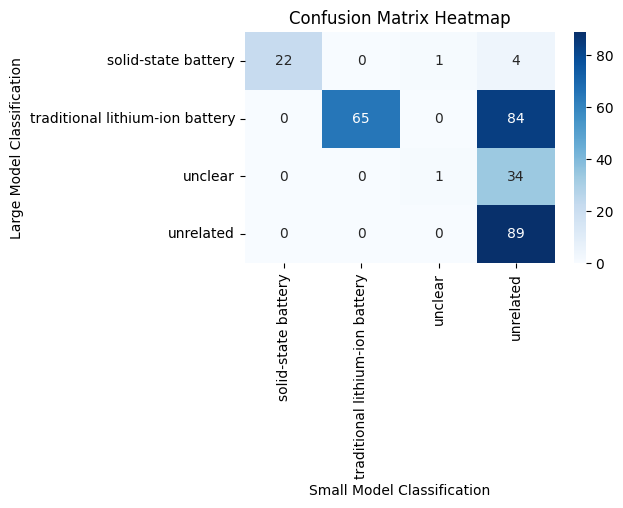

In [0]:
# Confusion Matrix Heatmap
pandas_df = df_results.select("large_classification", "small_classification").toPandas()

# Create a confusion matrix
confusion_matrix = pd.crosstab(pandas_df['large_classification'], pandas_df['small_classification'])

# Plot the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Small Model Classification')
plt.ylabel('Large Model Classification')
plt.show()

#### Classification Summary
- Small model has a bias towards classifying as unrelated.
- Solid-state battery classification accuracy: 22/27 correct.
- Traditional lithium-ion battery classification accuracy: 65/149 correct.
- Recommendation: Use (out of sample) false negatives as examples for few-shot prompting.

In [0]:
patent_classification_prompt_few_shot = """
BATTERY PATENT CLASSIFICATION

Analyze the patent text to determine if it pertains to solid-state batteries, traditional lithium-ion batteries, or if it's an unrelated patent. Look out for the following key indicators in the patent text.

**Key Indicators:**

**Solid-State Batteries:**
- Clear mention of solid electrolytes (ceramic or polymer)
- No separate separator present
- Specific architectures like thin films or bulk solid-state designs- Mention of materials such as LLZO, LAGP, or solid polymer electrolytes

**Traditional Li-ion Batteries:**
- Clear presence of liquid or gel electrolytes
- Mention of separators or membranes
- Reference to anodes, cathodes, or current collectors
- Focus on liquid solvents or polyethylene/polypropylene separators 

**Important Notes:**
- Look for explicit and unambiguous mentions of battery type.
- Some patents may discuss hybrid systems; classify as 'unclear' if it's not definitively one type.
- If the patent does not relate to batteries or their components, please classify as 'unrelated'.
- Use all of your evidence at hand to provide a confidence rating of high, medium or low.

**Output JSON Format:**
{
  "classification": "solid-state battery" | "traditional lithium-ion battery" | "unclear" | "unrelated",
  "confidence": "high" | "medium" | "low"
}

Please strictly adhere to this JSON format and do not provide any additional information. Review the following 3 examples carefully before classifying the subsequent patent.

Example 1:
**Patent Data**

Title: Wet atomizer

Abstract: Provided is a wet atomizer for processing all-solid-state battery raw materials while ensuring sealing property, operability after completion of processing, and maintenance property. The wet atomizer includes a liquid supply pump for supplying the all-solid-state battery raw materials, a pressure intensifier for pressurizing the all-solid-state battery raw materials supplied from the liquid supply pump, a high-pressure filter for filtering the all-solid-state battery raw materials pressurized by the pressure intensifier, a chamber for injecting the all-solid-state battery raw materials filtered by the high-pressure filter, a sealing member for sealing the space for processing the all-solid-state battery raw materials, and an inert gas supply unit for supplying an inert gas to the sealing member., Provided is a wet atomizer for processing all-solid-state battery raw materials while ensuring sealing property, operability after completion of processing, and maintenance property. The wet atomizer includes a liquid supply pump for supplying the all-solid-state battery raw materials, a pressure intensifier for pressurizing the all-solid-state battery raw materials supplied from the liquid supply pump, a high-pressure filter for filtering the all-solid-state battery raw materials pressurized by the pressure intensifier, a chamber for injecting the all-solid-state battery raw materials filtered by the high-pressure filter, a sealing member for sealing the space for processing the all-solid-state battery raw materials, and an inert gas supply unit for supplying an inert gas to the sealing member.

Claims: What is claimed is: 
     
         1 . A wet atomizer, comprising:
 a liquid supply pump configured to supply all-solid-state battery raw materials;   a pressure intensifier configured to pressurize the all-solid-state battery raw materials supplied from the liquid supply pump;   a high-pressure filter configured to filter the all-solid-state battery raw materials pressurized by the pressure intensifier;   a chamber configured to inject the all-solid-state battery raw materials filtered by the high-pressure filter;   a sealing member configured to seal a space for processing the all-solid-state battery raw materials; and   an inert gas supply unit configured to supply inert gas to the sealing member.   
     
     
         2 . The wet atomizer according to  claim 1 , further comprising:
 a raw material tank configured to store the all-solid-state battery raw materials;   wherein the inert gas supply unit includes
 an inert gas supply source configured to supply the inert gas, 
 a first inert gas supply path connecting the inert gas supply source to the sealing member, and 
 a second inert gas supply path connecting the inert gas supply source to the raw material tank. 
   
     
     
         3 . The wet atomizer according to  claim 1 , further comprising:
 a main body configured to be sealed with the sealing member; and   a sealing element configured to seal the main body and the sealing member,   wherein the main body has a first seal groove along an entire periphery,   the sealing member has a second seal groove along an entire periphery, and   the sealing element is fitted between the first seal groove and the second seal groove.   
     
     
         4 . The wet atomizer according to  claim 1 , wherein
 the chamber includes a ceramic wall on at least one surface inside the chamber.   
     
     
         5 . The wet atomizer according to  claim 1 , wherein
 the all-solid-state battery raw materials is sulfide-based solid electrolyte material.   
     
     
         6 . The wet atomizer according to  claim 1 , wherein
 the inert gas supply unit supply nitrogen or argon to the sealing member.   
     
     
         7 . The wet atomizer according to  claim 1 , further comprising:
 a gas circulation purification unit configured to circulate and purify the inert gas.   
     
     
         8 . The wet atomizer according to  claim 1 , wherein
 the gas circulation purification unit includes
 a purification unit configured to purify the inert gas or gas generated in the sealing member, and 
 a blower unit configured to circulate the inert gas or gas generated in the sealing member. 
   
     
     
         9 . The wet atomizer according to  claim 1 , wherein
 the sealing member includes
 a work glove operable under sealing environment inside the sealing member, 
 a work window configured to dispose the work glove, and 
 a take-out window configured to take in or take out the all-solid-state battery raw materials. 
   
     
     
         10 . The wet atomizer according to  claim 1 , wherein
 the sealing member includes a work robot configured to move the all-solid-state battery raw materials.   
     
     
         11 . The wet atomizer according to  claim 2 , further comprising:
 a main body configured to be sealed with the sealing member; and   a sealing element configured to seal the main body and the sealing member,   wherein the main body has a first seal groove along an entire periphery,   the sealing member has a second seal groove along an entire periphery, and   the sealing element is fitted between the first seal groove and the second seal groove.   
     
     
         12 . The wet atomizer according to  claim 2 , wherein
 the chamber includes a ceramic wall on at least one surface inside the chamber.   
     
     
         13 . The wet atomizer according to  claim 3 , wherein
 the chamber includes a ceramic wall on at least one surface inside the chamber.   
     
     
         14 . The wet atomizer according to  claim 2 , wherein
 the all-solid-state battery raw materials is sulfide-based solid electrolyte material.   
     
     
         15 . The wet atomizer according to  claim 3 , wherein
 the all-solid-state battery raw materials is sulfide-based solid electrolyte material.   
     
     
         16 . The wet atomizer according to  claim 4 , wherein
 the all-solid-state battery raw materials is sulfide-based solid electrolyte material.   
     
     
         17 . The wet atomizer according to  claim 2 , further comprising:
 a gas circulation purification unit configured to circulate and purify the inert gas.   
     
     
         18 . The wet atomizer according to  claim 3 , further comprising:
 a gas circulation purification unit configured to circulate and purify the inert gas.   
     
     
         19 . The wet atomizer according to  claim 4 , further comprising:
 a gas circulation purification unit configured to circulate and purify the inert gas.   
     
     
         20 . The wet atomizer according to  claim 5 , further comprising:
 a gas circulation purification unit configured to circulate and purify the inert gas.
{
  "classification": "solid-state battery",
  "confidence": "high"
}

Example 2:
**Patent Data**

Title: Solid ion conductor compound, solid electrolyte comprising same, electrochemical cell comprising same, and manufacturing method thereof

Abstract: Disclosed are a solid ion conductor compound represented by Formula 1,and having an argyrodite-type crystal structure, a solid electrolyte and an electrochemical cell each comprising the same, and a method of preparing the same:LixPyM1vSzM2wM3w′  &lt;Formula 1&gt;where in the above formula, M1 is an element substituted at P sites and having a larger ionic radius than that of P, M2 and M3 are different elements selected from elements of Group 17 in the periodic table, and 4≤x≤8, 0&lt;y&lt;1, 0&lt;v&lt;1, 0&lt;z&lt;6, 0&lt;w&lt;3, 0≤w′&lt;3, and y≥v., Disclosed are a solid ion conductor compound represented by Formula 1,
         and having an argyrodite-type crystal structure, a solid electrolyte and an electrochemical cell each comprising the same, and a method of preparing the same:       

       Li x P y M 1   v S z M 2   w M 3   w′   &lt;Formula  1&gt; 
         where in the above formula, M1 is an element substituted at P sites and having a larger ionic radius than that of P, M2 and M3 are different elements selected from elements of Group 17 in the periodic table, and 4≤x≤8, 0&lt;y&lt;1, 0&lt;v&lt;1, 0&lt;z&lt;6, 0&lt;w&lt;3, 0≤w′&lt;3, and y≥v.

Claims: 1 . A solid ion conductor compound represented by Formula 1 below and having an argyrodite-type crystal structure:
   Li x P y M1 v S z M2 w M3 w′   Formula 1&gt;
   wherein, in Formula 1,   M1 is an element substituted at P sites and having a larger ionic radius than that of P,   M2 and M3 are different elements selected from elements of Group 17 in the periodic table, and   4≤x≤8, 0&lt;y&lt;1, 0&lt;v&lt;1, 0&lt;z&lt;6, 0&lt;w&lt;3, 0≤w′&lt;3, and y≥v.   
     
     
         2 . The solid ion conductor compound of  claim 1 , wherein in Formula 1, w+w′≥1. 
     
     
         3 . The solid ion conductor compound of  claim 1 , wherein in Formula 1, 0&lt;v/(y+v)&lt;0.5 and 0.1≤(w+w′)/(z+w+w′)≤0.5. 
     
     
         4 . The solid ion conductor compound of  claim 1 , wherein M1 is at least one element, other than P, selected from elements belonging to Groups 3 to 15 in the periodic table. 
     
     
         5 . The solid ion conductor compound of  claim 1 , wherein M1 comprises Sc, Y, Ti, Zr, Hf, V, Nb, Ta, Cr, Mo, W, Mn, Tc, Re, Fe, Ru, Os, Co, Rh, Ir, Ni, Pd, Pt, Cu, Ag, Au, Zn, Cd, Hg, Al, Ga, In, Tl, Si, Ge, Sn, Pb, As, Sb, Bi, or a combination thereof. 
     
     
         6 . The solid ion conductor compound of  claim 1 , wherein M1 comprises Si, Ge, Sn, or a combination thereof. 
     
     
         7 . The solid ion conductor compound of  claim 1 , wherein M2 and M3 comprise different elements selected from F, Cl, Br, I, or a combination thereof. 
     
     
         8 . The solid ion conductor compound of  claim 1 , wherein the solid ion conductor compound represented by Formula 1 is represented by Formula 2 below:
   Li 7+a−(b+c) P 1−a M1 a S 6−(b+c) M2 b M3 c    &lt;Formula 2&gt;
   wherein, in Formula 2,   M1 is Sc, Y, Ti, Zr, Hf, V, Nb, Ta, Cr, Mo, W, Mn, Tc, Re, Fe, Ru, Os, Co, Rh, Ir, Ni, Pd, Pt, Cu, Ag, Au, Zn, Cd, Hg, Al, Ga, In, Tl, Si, Ge, Sn, Pb, As, Sb, Bi, or a combination thereof,   M2 and M3 different elements selected from F, Cl, Br, I, and a combination thereof, and 0&lt;a≤0.5, 0&lt;b&lt;3, and 0≤c&lt;3.   
     
     
         9 . The solid ion conductor compound of  claim 8 , wherein in Formula 2, 0&lt;a&lt;0.5 and b+c≥1. 
     
     
         10 . The solid ion conductor compound of  claim 1 , wherein the solid ion conductor compound represented by Formula 1 is represented by at least one of Formulae 2a to 2c below:
   Li 7+a−(b+c) P 1−a Ge a S 6−(b+c) M2 b M3 c ;   &lt;Formula 2a&gt;
     Li 7+a−(b+c) P 1−a Si a S 6−(b+c) M2 b M3 c ; and &lt;Formula 2b&gt;     Li 7+a−(b+c) P 1−a Sn a S 6−(b+c) M2 b M3 c    &lt;Formula 2c&gt;
   wherein, in Formulae 2a, 2b, and 2c,   M2 and M3 are different elements selected from F, Cl, Br, I, and a combination thereof, and   0&lt;a≤0.5, 0&lt;b&lt;3, 0≤c&lt;3 and b+c≥1.   
     
     
         11 . The solid ion conductor compound of  claim 1 , wherein:
 the solid ion conductor compound represented by Formula 1 is represented by one of the formulae below:
   Li 7+a−(b+c) P 1−a Ge a S 6−(b+c) Cl b Br c ; Li 7+a−(b+c) P 1−a Si a S 6−(b+c) Cl b Br c ; Li 7+a−(b+c) P 1−a Sn a S 6−(b+c) Cl b Br c ; 
   Li 7+a−(b+c) P 1−a Ge a S 6−(b+c) Cl b I c ; Li 7+a−(b+c) P 1−a Si a S 6−(b+c) Cl b I c ; Li 7+a−(b+c) P 1−a Sn a S 6−(b+c) Cl b I c ; 
   Li 7+a−(b+c) P 1−a Ge a S 6−(b+c) Br b I c ; Li 7+a−(b+c) P 1−a Si a S 6−(b+c) Br b I c ; and Li 7+a−(b+c) P 1−a Sn a S 6−(b+c) Br b I c , 
   in the above formulae, 0&lt;a≤0.5, 0≤b&lt;3, 0≤c&lt;3 and b+c≥1.   
     
     
         12 . The solid ion conductor compound of  claim 1 , wherein the solid ion conductor compound represented by Formula 1 has some Li sites further substituted with at least one element M4 selected from elements of Groups 1 to 15 in the periodic table. 
     
     
         13 . The solid ion conductor compound of  claim 12 , wherein the at least one element M4 includes Na, K, Mg, Ag, Cu, Hf, In, Ti, Pb, Sb, Fe, Zr, Zn, Cr, B, Sn, Ge, Si, Zr, Ta, Nb, V, Ga, Al, As, or a combination thereof. 
     
     
         14 . The solid ion conductor compound of  claim 12 , wherein in Formula 1, when a substitution amount of the at least one element M4 selected from elements of Groups 1 to 15 in the periodic table is denoted by u, 0&lt;u&lt;0.5. 
     
     
         15 . The solid ion conductor compound of  claim 1 , wherein the solid ion conductor compound represented by Formula 1 has some S sites further substituted with SO n , in which 1.5≤n≤5. 
     
     
         16 . The solid ion conductor compound of  claim 15 , wherein when an amount of the SO n  is u′, 0&lt;u′&lt;2. 
     
     
         17 . The solid ion conductor compound of  claim 1 , wherein the solid ion conductor compound represented by Formula 1 provides an ionic conductivity of 1.0 mS/cm or greater at 25° C. 
     
     
         18 . The solid ion conductor compound of  claim 1 , wherein:
 the solid ion conductor compound represented by Formula 1 has an ionic conductivity retention ratio of 70% or greater after exposure to dry air at a dew point of lower than −60° C. for 10 days, and   the ionic conductivity retention ratio is represented by Equation 1 below:
   Ionic conductivity retention ratio=[Ionic conductivity of solid ion conductor compound after 10 days/Initial ionic conductivity of solid ion conductor compound]×100.   &lt;Equation 1&gt;
 
   
     
     
         19 . A solid electrolyte comprising the solid ion conductor compound of  claim 1 . 
     
     
         20 . An electrochemical cell comprising:
 a cathode layer including a cathode active material layer;   an anode layer including an anode active material layer; and   an electrolyte layer disposed between the cathode layer and the anode layer,   wherein the cathode layer and the anode layer each include the solid ion conductor compound as claimed in  claim 1 .   
     
     
         21 . The electrochemical cell of  claim 20 , wherein the electrochemical cell is an all-solid secondary battery. 
     
     
         22 . The electrochemical cell of  claim 20 , wherein:
 the anode active material layer includes an anode active material and a binder, and   the anode active material is a mixture of amorphous carbon and one or more of gold (Au), silver (Ag), aluminum (Al), bismuth (Bi), tin (Sn), and zinc (Zn).   
     
     
         23 . The electrochemical cell of  claim 20 , further comprising a metal layer disposed between an anode current collector of the anode layer and the anode active material layer, wherein the metal layer comprises lithium or a lithium alloy. 
     
     
         24 . A method of preparing a solid ion conductor compound, the method comprising:
 providing a mixture by contacting two or more compounds comprising: a lithium-containing compound; one or more compounds containing an element, other than P, selected from elements belonging to Groups 3 to 15 in the periodic table and having an ionic radius larger than that of P; and different elements of Group 17 in the periodic table; and   thermally treating the mixture in an inert atmosphere to provide the solid ion conductor compound.   
     
     
         25 . The method of  claim 24 , wherein the thermal treatment is performed at a temperature of 400° C. to 600° C. for 1 to 36 hours.
{
  "classification": "solid-state battery",
  "confidence": "high"
}

Example 3:
**Patent Data**

Title: Battery module and manufacturing method for the same

Abstract: A battery module includes at least one battery cell array including a cell frame and a plurality of battery cells, each battery cell having electrode terminals disposed at both ends of each battery cell and oriented toward the same direction, the plurality of battery cells being disposed in a lateral direction when mounted in the cell frame; and a plurality of connection members attached to the electrode terminals of a respective battery cell of the at least one battery cell array at an upper portion, a lower portion, or both of the at least one battery cell array, wherein each connection member is a metal plate having at least three vertical slits that are spaced apart from each other and a horizontal slit that crosses at least one of the vertical slits., A battery module includes at least one battery cell array including a cell frame and a plurality of battery cells, each battery cell having electrode terminals disposed at both ends of each battery cell and oriented toward the same direction, the plurality of battery cells being disposed in a lateral direction when mounted in the cell frame; and a plurality of connection members attached to the electrode terminals of a respective battery cell of the at least one battery cell array at an upper portion, a lower portion, or both of the at least one battery cell array, wherein each connection member is a metal plate having at least three vertical slits that are spaced apart from each other and a horizontal slit that crosses at least one of the vertical slits.

Claims: The invention claimed is: 
     
       1. A battery module, comprising:
 at least one battery cell array including a cell frame and a plurality of battery cells, each battery cell having electrode terminals disposed at both ends of each battery cell and oriented toward the same direction, the plurality of battery cells being disposed in a lateral direction when mounted in the cell frame; and 
 a plurality of connection members attached to the electrode terminals of a respective battery cell of the at least one battery cell array at an upper portion, a lower portion, or both of the at least one battery cell array, 
 wherein each connection member is a metal plate having at least three vertical slits that are spaced apart from each other and a horizontal slit that crosses at least one of the vertical slits, 
 wherein the at least three vertical slits include: 
 a first slit connected to one end of the horizontal slit; 
 a second slit connected to another end of the horizontal slit; and 
 a third slit which crosses the horizontal slit between the first slit and the second slit, and 
 wherein a length of the third slit is larger than 100% and smaller than 130% of a length of the first slit or a length the second slit, 
 wherein each connection member includes two or more resistance welding units set between adjacent vertical slits among the at least three vertical slits, 
 wherein each of the two or more resistance welding units is partitioned into a first welding unit in an upper direction and a second welding unit in a lower direction with respect to the horizontal slit, 
 wherein the two or more resistance welding units set in each connection member are resistively welded to the electrode terminals of the respective battery cell, and 
 wherein each connection member includes a current application path along one of the at least three vertical slits configured so that the current application path taken by a reactive current from the first welding unit to the second welding unit is extended along the one of the at least three vertical slits. 
 
     
     
       2. The battery module of  claim 1 , wherein the metal plate includes an alloy of copper as a first material and at least one metal selected from a group consisting of zinc, nickel, aluminum, platinum, lead, tin, and stainless steel as a second material. 
     
     
       3. The battery module of  claim 1 , wherein the third slit is perpendicular to the horizontal slit. 
     
     
       4. The battery module of  claim 1 , wherein the third slit forms an angle of 20 degrees to 160 degrees with respect to the horizontal slit. 
     
     
       5. The battery module of  claim 1 , wherein the first slit and the second slit are perpendicular to the horizontal slit. 
     
     
       6. The battery module of  claim 1 , wherein:
 the first slit and the second slit have a wedge shape curved with respect to a portion connected to the horizontal slit and an internal angle of the wedge shape is 120 degrees or larger and less than 180 degrees. 
 
     
     
       7. The battery module of  claim 1 , wherein the first slit and the second slit are connected to the horizontal slit with a curved line on plan view. 
     
     
       8. The battery module of  claim 1 , wherein each battery cell is a cylindrical battery cell comprising:
 a cylindrical metal can that is closed and sealed as a top cap assembly; 
 an electrode assembly and an electrolytic solution embedded in the cylindrical metal can. 
 
     
     
       9. A method of manufacturing the battery module of  claim 1 , the method comprising:
 pressurizing a connection member among a plurality of connection members to an electrode terminal of a battery cell among the plurality of battery cells; 
 initially bonding the two or more resistance welding units and the electrode terminals by disposing welding rods in the first welding unit and the second welding unit of a resistance welding unit adjacent to a first slit among the at least three vertical slits and forming an active current which passes through an electrode terminal among the electrode terminals between the welding rods; and 
 disposing the welding rods in the first welding unit and the second welding unit of the resistance welding unit adjacent to a second slit among the at least three vertical slits and forming the active current which passes through the electrode terminal between the welding rods to additionally bond the resistance welding unit and the electrode terminal. 
 
     
     
       10. The method of  claim 9 , wherein in the initial bonding, a reactive current which does not pass through the electrode terminal is additionally formed between the welding rods, and
 wherein the reactive current is applied to the second welding unit along a periphery of the first slit of the connection member from the first welding unit. 
 
     
     
       11. The method of  claim 9 , wherein in the additional bonding, a reactive current which does not pass through the electrode terminal is additionally formed between the welding rods,
 wherein the reactive current is applied to the second welding unit along a periphery of a third slit among the at least three vertical slits of the connection member from the first welding unit, and 
 wherein at the time of current application, the reactive current passes through the electrode terminal bonded in the initial bonding. 
 
     
     
       12. The battery module of  claim 1 , wherein the third slit is not parallel to the first slit and the second slit. 
     
     
       13. The battery module of  claim 1 , wherein the first slit is not parallel to the second slit.
{
  "classification": "traditional lithium-ion battery",
  "confidence": "high"
}
"""

In [0]:
df_results = compare_models(df_content_sample, patent_classification_prompt_few_shot, large_model, small_model)

df_results.display()

publication_number large_classification large_confidence small_classification small_confidence US-2022200061-A1 unclear low unrelated high US-2020324828-A1 unrelated high unrelated high US-10854879-B2 traditional lithium-ion battery high unrelated high US-2023108811-A1 traditional lithium-ion battery medium unrelated high US-2022077445-A1 traditional lithium-ion battery high unrelated high US-2023050718-A1 traditional lithium-ion battery high unrelated high US-11483824-B2 unrelated high unrelated high US-2023113133-A1 traditional lithium-ion battery medium unrelated high US-2020373532-A1 traditional lithium-ion battery medium unrelated high US-2022404186-A1 traditional lithium-ion battery medium unrelated high US-10903495-B2 traditional lithium-ion battery medium unrelated high US-2022140418-A1 traditional lithium-ion battery medium unrelated high US-11569502-B2 solid-state battery high solid-state battery high US-2022134400-A1 unrelated high unrelated high US-2022238936-A1 traditional lithium-ion battery medium unrelated high US-2021126289-A1 traditional lithium-ion battery high traditional lithium-ion battery high US-10787752-B2 traditional lithium-ion battery high unrelated high US-2022393274-A1 unclear medium unrelated high US-11094997-B2 traditional lithium-ion battery high traditional lithium-ion battery high US-2020036060-A1 unrelated high unrelated high US-2022045408-A1 traditional lithium-ion battery high traditional lithium-ion battery high US-11466040-B2 unrelated high unrelated high US-2022143911-A1 unrelated high unrelated high US-11152608-B2 traditional lithium-ion battery high traditional lithium-ion battery high US-11557751-B2 solid-state battery high solid-state battery high US-10854924-B2 traditional lithium-ion battery high unrelated high US-2020251698-A1 traditional lithium-ion battery high unrelated high US-11658343-B2 traditional lithium-ion battery high unrelated high US-2021119256-A1 traditional lithium-ion battery high unrelated high US-10658673-B2 traditional lithium-ion battery high traditional lithium-ion battery high US-2023163396-A1 unrelated high unrelated high US-2021305652-A1 traditional lithium-ion battery medium unrelated high US-10700355-B2 traditional lithium-ion battery high unrelated high US-D973580-S unclear low unrelated high US-2023105976-A1 traditional lithium-ion battery medium unrelated high US-2021159553-A1 traditional lithium-ion battery medium unrelated high US-2023129184-A1 unrelated high unrelated high US-11654599-B2 unrelated high unrelated high US-11186137-B2 unrelated high unrelated high US-2022149436-A1 traditional lithium-ion battery high traditional lithium-ion battery high US-2022190409-A1 unrelated high unrelated high US-2023060509-A1 traditional lithium-ion battery high traditional lithium-ion battery high US-10777850-B2 traditional lithium-ion battery high unrelated high US-10536019-B2 traditional lithium-ion battery medium unrelated high US-2023027935-A1 unrelated high unrelated high US-11434581-B2 unrelated high unrelated high US-11094987-B2 unrelated high traditional lithium-ion battery high US-10714790-B2 traditional lithium-ion battery high traditional lithium-ion battery high US-11258095-B2 solid-state battery high solid-state battery high US-11575132-B2 traditional lithium-ion battery high unrelated high US-2022389310-A1 unrelated high unrelated high US-11094985-B2 traditional lithium-ion battery high unrelated high US-2022009818-A1 unrelated high unrelated high US-2021391597-A1 traditional lithium-ion battery high unrelated high US-11664501-B2 traditional lithium-ion battery high unrelated high US-2022166109-A1 traditional lithium-ion battery high unrelated high US-11495847-B2 traditional lithium-ion battery high traditional lithium-ion battery high US-10763460-B2 traditional lithium-ion battery high traditional lithium-ion battery high US-2021351440-A1 traditional lithium-ion battery high traditional lithium-ion battery high US-11575147-B2 solid-state battery

In [0]:
# Save and upload results
df_results = spark.read.csv("/Volumes/workspace/default/kaggle_filtered_2/few_shot_prompt_results.csv", header=True)

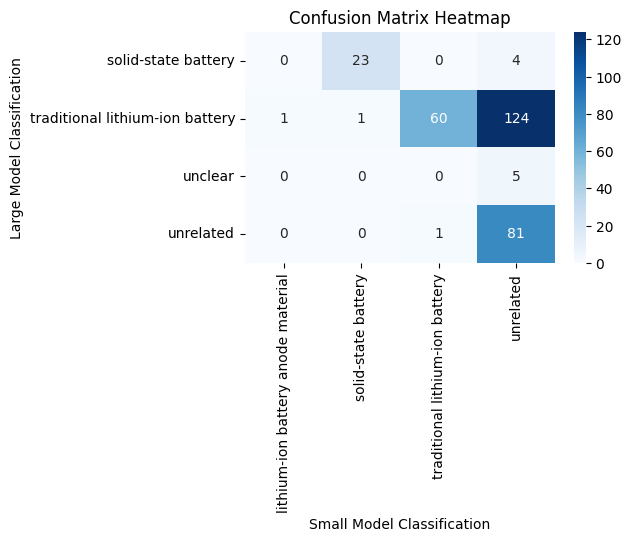

In [0]:
# Confusion Matrix Heatmap
pandas_df = df_results.select("large_classification", "small_classification").toPandas()

# Create a confusion matrix
confusion_matrix = pd.crosstab(pandas_df['large_classification'], pandas_df['small_classification'])

# Plot the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Small Model Classification')
plt.ylabel('Large Model Classification')
plt.show()

#### Classification Summary
- Longer inference time
- Minor improvement in solid state false negatives
- 3/4 of the False negatives are only medium confidence in the large model
- 1 false positive
- New category accidentally introduced
- Worse classification for lith-ion


#### Full dataset classification with original prompt

In [0]:
df_content = df_content.withColumn("index", F.monotonically_increasing_id())

In [0]:
batch_df = df_content.filter("index >= 3758 and index < 5000")
df_results = classify_patents(batch_df, patent_classification_prompt, small_model)
df_results.display()

publication_number small_classification small_confidence

In [0]:
df1 = spark.read.csv("/Volumes/workspace/default/kaggle_filtered_2/export (23).csv", header=True, inferSchema=True)
df2 = spark.read.csv("/Volumes/workspace/default/kaggle_filtered_2/export (24).csv", header=True, inferSchema=True)
df3 = df1.union(df2)
display(df3)

publication_number small_classification small_confidence US-11600849-B2 unrelated high US-11616252-B2 traditional lithium-ion battery high US-2023062095-A1 unrelated high US-11611092-B2 unrelated high US-2023089216-A1 unrelated high US-11603451-B2 unrelated high US-2023082369-A1 unrelated high US-2023071177-A1 solid-state battery high US-2023080226-A1 traditional lithium-ion battery high US-2023080280-A1 unrelated high US-11600862-B2 traditional lithium-ion battery high US-11607728-B2 unrelated high US-11611102-B2 unrelated high US-2023082796-A1 unrelated high US-11597611-B2 unrelated high US-11602176-B2 unrelated high US-2023090001-A1 unrelated high US-11605807-B2 unclear medium US-2023063338-A1 unrelated high US-2023076747-A1 unrelated high US-2023091305-A1 unrelated high US-11597719-B2 unrelated high US-2023080549-A1 unrelated high US-2023099793-A1 unrelated high US-11605852-B2 traditional lithium-ion battery high US-2023079279-A1 unrelated high US-2023099240-A1 unrelated high US-2023064293-A1 unrelated high US-2023084862-A1 unrelated high US-2023072437-A1 unrelated high US-2023099713-A1 unrelated high US-2023065685-A1 unrelated high US-2023101343-A1 unrelated high US-2023065154-A1 traditional lithium-ion battery medium US-2023076263-A1 unrelated high US-2023080258-A1 unrelated high US-2023094245-A1 unrelated high US-2023097233-A1 unrelated high US-2023080881-A1 unrelated high US-11603427-B2 unrelated high US-2023100503-A1 unrelated high US-2023064836-A1 unrelated high US-2023067336-A1 unrelated high US-2023072704-A1 unrelated high US-11616246-B2 unrelated high US-2023070599-A1 unrelated high US-2023095550-A1 traditional lithium-ion battery high US-2023081939-A1 unrelated high US-11600865-B2 unrelated high US-11616380-B2 unrelated high US-2023098167-A1 traditional lithium-ion battery high US-11611076-B2 unrelated high US-2023060634-A1 unrelated high US-2023098629-A1 unrelated high US-2023098705-A1 solid-state battery high US-2023088113-A1 solid-state battery high US-2023102013-A1 unrelated high US-2023079409-A1 traditional lithium-ion battery medium US-2023085886-A1 traditional lithium-ion battery high US-2023098901-A1 unrelated high US-2023070433-A1 unrelated high US-2023072647-A1 unrelated high US-2023098257-A1 solid-state battery high US-11613219-B2 unrelated high US-2023101947-A1 traditional lithium-ion battery high US-2023080952-A1 unrelated high US-2023099231-A1 unrelated high US-2023088137-A1 unrelated high US-11613172-B2 unrelated high US-2023076834-A1 unclear medium US-2023074642-A1 solid-state battery high US-2023088432-A1 traditional lithium-ion battery high US-2023088894-A1 unrelated high US-11611081-B2 traditional lithium-ion battery high US-11611114-B2 unrelated high US-2023061013-A1 unrelated high US-2023076191-A1 traditional lithium-ion battery high US-2023074459-A1 unrelated high US-2023076517-A1 unrelated high US-2023096724-A1 solid-state battery high US-2023098222-A1 unrelated high US-11600872-B2 unrelated high US-2023068174-A1 unrelated high US-2023080484-A1 unrelated high US-2023083508-A1 unrelated high US-2023080880-A1 unrelated high US-11611116-B2 unrelated high US-2023097978-A1 unrelated high US-2023094134-A1 unrelated high US-2023088592-A1 unrelated high US-11616275-B2 unrelated high US-2023086598-A1 traditional lithium-ion battery high US-2023087166-A1 unrelated high US-2023079447-A1 all solid state battery high US-2023090482-A1 unrelated high US-2023075536-A1 solid-state battery high US-2023080239-A1 unrelated high US-2023061304-A1 unrelated high US-2023074353-A1 solid-state battery medium US-2023062758-A1 unrelated high US-D980160-S unrelated high US-2023090639-A1 traditional lithium-ion battery high US-2023073699-A1 traditional lithium-ion battery high US-11616239-B2 unrelated high US-2023088451-A1 traditional lithium-ion battery high US-2023062173-A1 unrelated high US-2023085778-A1 traditional lithium-ion battery high US-11604228-B2 unrelated high US-2023071423-A1 unrelated high US-2023085545-A

In [0]:
df_grouped = df3.groupBy("small_classification").count()
display(df_grouped)

small_classification count all solid state battery 1 unrelated 2717 solid-state battery 231 traditional lithium-ion battery 660 unclear 18 all-solid state sodium secondary battery 1

In [0]:
df_filtered = df3.filter((df3.small_classification == "solid-state battery") | 
                         (df3.small_classification == "all solid state battery") | 
                         (df3.small_classification == "all-solid state sodium secondary battery"))
display(df_filtered)

publication_number small_classification small_confidence US-2023071177-A1 solid-state battery high US-2023098705-A1 solid-state battery high US-2023088113-A1 solid-state battery high US-2023098257-A1 solid-state battery high US-2023074642-A1 solid-state battery high US-2023096724-A1 solid-state battery high US-2023079447-A1 all solid state battery high US-2023075536-A1 solid-state battery high US-2023074353-A1 solid-state battery medium US-11605833-B2 solid-state battery high US-2023084047-A1 solid-state battery high US-2023102360-A1 solid-state battery high US-11605819-B2 solid-state battery high US-2023099194-A1 solid-state battery high US-2023067637-A1 solid-state battery high US-11600826-B2 solid-state battery high US-2023070626-A1 solid-state battery high US-2023088683-A1 solid-state battery high US-2023064555-A1 solid-state battery high US-11605834-B2 solid-state battery high US-2023094026-A1 solid-state battery high US-2023064294-A1 solid-state battery high US-2023096123-A1 solid-state battery high US-2023074539-A1 solid-state battery high US-2023074308-A1 solid-state battery high US-2023080081-A1 solid-state battery high US-2023080525-A1 solid-state battery high US-2023083614-A1 solid-state battery high US-11641033-B2 solid-state battery high US-11646442-B2 solid-state battery high US-2023163354-A1 solid-state battery high US-2023133563-A1 solid-state battery high US-11646445-B2 solid-state battery high US-11646401-B2 solid-state battery high US-2023150831-A1 solid-state battery high US-2023140520-A1 solid-state battery high US-11641030-B2 solid-state battery high US-2023155171-A1 solid-state battery high US-2023146958-A1 solid-state battery high US-2023145927-A1 solid-state battery high US-11652236-B2 solid-state battery high US-11642971-B2 solid-state battery high US-2023146632-A1 solid-state battery high US-2023144563-A1 solid-state battery high US-2023163351-A1 solid-state battery high US-2023084565-A1 solid-state battery high US-11600853-B1 solid-state battery high US-2023075778-A1 solid-state battery high US-2023102548-A1 solid-state battery high US-2023065906-A1 solid-state battery high US-2023096142-A1 solid-state battery high US-2023102140-A1 solid-state battery high US-2023067002-A1 solid-state battery high US-11600851-B2 solid-state battery high US-2023066390-A1 solid-state battery high US-2023091921-A1 solid-state battery high US-2023076596-A1 solid-state battery medium US-2023069196-A1 solid-state battery high US-2023100845-A1 solid-state battery high US-2023077307-A1 solid-state battery high US-2023092765-A1 solid-state battery high US-2023083742-A1 solid-state battery high US-11616222-B2 solid-state battery high US-2023076099-A1 solid-state battery high US-11600846-B2 solid-state battery high US-2023100540-A1 solid-state battery high US-2023099184-A1 solid-state battery high US-11600855-B2 solid-state battery high US-2023083305-A1 solid-state battery high US-11600852-B2 solid-state battery high US-11614493-B2 solid-state battery high US-2023093244-A1 solid-state battery high US-11600850-B2 solid-state battery high US-11611110-B2 solid-state battery high US-2023100780-A1 solid-state battery high US-2023090263-A1 solid-state battery high US-2023096228-A1 solid-state battery high US-2023079071-A1 solid-state battery high US-2023090892-A1 solid-state battery high US-2023098496-A1 solid-state battery high US-2023066483-A1 solid-state battery high US-11611104-B2 solid-state battery high US-2023093098-A1 solid-state battery high US-11600854-B2 solid-state battery high US-2023075357-A1 solid-state battery high US-2023086265-A1 solid-state battery high US-11611103-B2 solid-state battery high US-2023063684-A1 solid-state battery high US-2023060930-A1 solid-state battery high US-2023094366-A1 solid-state battery high US-2023074796-A1 solid-state battery high US-11597989-B2 solid-state battery high US-2023103232-A1 solid-state battery high US-2023061385-A1 solid-state battery high US-2023097853-A1 solid-state batter

In [0]:
# Read in patents filtered based on codes
df_content = spark.read.parquet("/Volumes/workspace/default/kaggle_filtered_1/patents.parquet/")


In [0]:
df_content_filtered = df_content.join(df_filtered.select(df_filtered.publication_number), "publication_number", "inner")
df_content_filtered.limit(5).display()
df_content_filtered.count()

publication_number title abstract claims description publication_date filing_date family_id cpc_codes US-2023071177-A1 Battery, battery exterior, and measurement method A battery includes: a power generating element including a first electrode layer, a second electrode layer, and a first solid electrolyte layer located between the first electrode layer and the second electrode layer; and a reference electrode section including a second solid electrolyte layer having a first main surface in contact with a side surface of the power generating element and a second main surface opposite to the first main surface, and a reference electrode in contact with the second main surface of the second solid electrolyte layer, in which a length of the first main surface is longer than a length of the side surface in a laminating direction in the power generating element., A battery includes: a power generating element including a first electrode layer, a second electrode layer, and a first solid electrolyte layer located between the first electrode layer and the second electrode layer; and a reference electrode section including a second solid electrolyte layer having a first main surface in contact with a side surface of the power generating element and a second main surface opposite to the first main surface, and a reference electrode in contact with the second main surface of the second solid electrolyte layer, in which a length of the first main surface is longer than a length of the side surface in a laminating direction in the power generating element. What is claimed is: 
 
 1 . A battery comprising:
 a power generating element including a first electrode layer, a second electrode layer, and a first solid electrolyte layer located between the first electrode layer and the second electrode layer; and a reference electrode section including a second solid electrolyte layer having a first main surface in contact with a side surface of the power generating element and a second main surface opposite to the first main surface, and a reference electrode in contact with the second main surface of the second solid electrolyte layer, wherein a length of the first main surface is longer than a length of the side surface in a laminating direction in the power generating element. 
 
 
 2 . The battery according to claim 1 , wherein
 the first solid electrolyte layer and the second solid electrolyte layer have lithium-ion conductivity. 
 
 
 3 . The battery according to claim 1 , wherein
 the reference electrode contains at least one of metallic lithium, a lithium alloy, or a lithium compound. 
 
 
 4 . The battery according to claim 1 , comprising a plurality of power generating elements laminated, each of which being the power generating element included in the battery. 
 
 
 5 . The battery according to claim 4 , wherein
 the first main surface is in contact with the plurality of power generating elements. 
 
 
 6 . The battery according to claim 1 , further comprising an exterior covering the power generating element and the reference electrode section. 
 
 
 7 . The battery according to claim 6 , wherein
 the exterior has a first cavity extending in a first direction and a second cavity extending in a second direction crossing the first direction and communicating with the first cavity, the power generating element is in contact with an inner surface of the exterior forming the first cavity, and the reference electrode section is in contact with an inner surface of the exterior forming the second cavity. 
 
 
 8 . The battery according to claim 7 , wherein
 at least one of the first cavity or the second cavity has a cylindrical shape. 
 
 
 9 . The battery according to claim 7 , wherein
 a portion of the exterior in contact with the power generating element and the reference electrode section contains a resin material. 
 
 
 10 . The battery according to claim 7 , wherein
 the exterior has a first exterior section in contact with the power gen

233

In [0]:
df_content_filtered.write.format("delta").saveAsTable("solid_state_battery_patents_sample")

In [0]:
df_solid_state_battery = spark.read.table("solid_state_battery_patents_sample")
df_solid_state_battery.display()

publication_number title abstract claims description publication_date filing_date family_id cpc_codes US-11600844-B2 Solid-state battery cell and solid-state battery module The present invention provides a solid-state battery cell and a solid-state battery module including the same. The solid-state battery cell includes: a laminate including a positive electrode layer, a negative electrode layer, and a solid electrolyte layer present between the positive electrode layer and the negative electrode layer; a positive electrode tab connected to the positive electrode layer; a negative electrode tab connected to the negative electrode layer; and a pair of conductive clamping plates clamping the laminate from both sides in a laminating direction of the laminate. One of the pair of clamping plates is electrically connected to the positive electrode tab, and the other clamping plate is electrically connected to the negative electrode tab., The present invention provides a solid-state battery cell and a solid-state battery module including the same. The solid-state battery cell includes: a laminate including a positive electrode layer, a negative electrode layer, and a solid electrolyte layer present between the positive electrode layer and the negative electrode layer; a positive electrode tab connected to the positive electrode layer; a negative electrode tab connected to the negative electrode layer; and a pair of conductive clamping plates clamping the laminate from both sides in a laminating direction of the laminate. One of the pair of clamping plates is electrically connected to the positive electrode tab, and the other clamping plate is electrically connected to the negative electrode tab. What is claimed is: 
 
 1. A solid-state battery cell, comprising:
 a laminate including a positive electrode layer, a negative electrode layer, and a solid electrolyte layer present between the positive electrode layer and the negative electrode layer; 
 a positive electrode tab connected to the positive electrode layer; 
 a negative electrode tab connected to the negative electrode layer; and 
 a pair of conductive clamping plates clamping the laminate from both sides in a laminating direction of the laminate, 
 wherein 
 one of the pair of clamping plates is electrically connected to the positive electrode tab, and the other clamping plate is electrically connected to the negative electrode tab, 
 each of the pair of clamping plates includes a conductive support plate that supports a face of the laminate perpendicular to the laminating direction, 
 a conductive holding member holds the laminate and the support plate in the laminating direction, and 
 each of the positive electrode tab and the negative electrode tab is electrically connected to the support plate and the holding member. 
 
 
 
 2. The solid-state battery cell of claim 1 , wherein the positive electrode tab and the negative electrode tab are arranged on the same end face of the laminate perpendicular to the laminating direction. 
 
 
 3. The solid-state battery cell of claim 2 , wherein the positive electrode tab is arranged on one side of the laminate in a direction perpendicular to the laminating direction on the same end face, and
 the negative electrode tab is arranged on the other side of the laminate in the direction perpendicular to the laminating direction on the same end face. 
 
 
 
 4. The solid-state battery cell of claim 1 , wherein the positive electrode tab is arranged on an end face of the laminate on one side in a direction perpendicular to the laminating direction, and
 the negative electrode tab is arranged on an end face of the laminate opposite to the end face on the one side. 
 
 
 
 5. The solid-state battery cell of claim 4 , wherein each of the positive electrode tab and the negative electrode tab is arranged to extend over the laminate in a direction perpendicular to the laminating direction when in plan view. 
 
 
 6. A solid-state battery module, c